### Principal Component Analysis

In the Abalone dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the 'Height' and 'Diameter' of their shells.

You could imagine that within this data are "axes of variation" that describe the ways the abalone tend to differ from one another. Pictorially, these axes appear as perpendicular lines running along the natural dimensions of the data, one axis for each original feature.

![image.png](assets/rr8NCDy.png "test")

Often, we can give names to these axes of variation. The longer axis we might call the "Size" component: small height and small diameter (lower left) contrasted with large height and large diameter (upper right). The shorter axis we might call the "Shape" component: small height and large diameter (flat shape) contrasted with large height and small diameter (round shape).

Notice that instead of describing abalones by their 'Height' and 'Diameter', we could just as well describe them by their 'Size' and 'Shape'. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]

### PCA for Feature Engineering

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

- **Dimensionality reduction**: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- **Anomaly detection**: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- **Noise reduction**: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- **Decorrelation**: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.


### PCA Best Practices
There are a few things to keep in mind when applying PCA:
- PCA only works with numeric features, like continuous quantities or counts.
- PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
- Consider removing or constraining outliers, since they can have an undue influence on the results.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("input/fe-course-data/autos.csv")

In [10]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

X.head()

,highway_mpg,engine_size,horsepower,curb_weight
0,27,130,111,2548
1,27,130,111,2548
2,26,152,154,2823
3,30,109,102,2337
4,22,136,115,2824


In [14]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

(193, 4)


,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [5]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings


,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


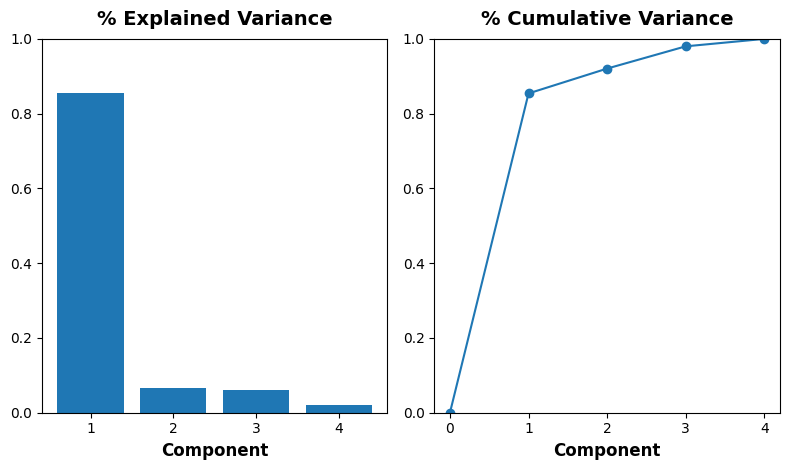

In [6]:
# Look at explained variance
plot_variance(pca);

In [7]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.012479
PC2    0.379597
PC3    0.307703
PC4    0.203507
Name: MI Scores, dtype: float64

In [8]:
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


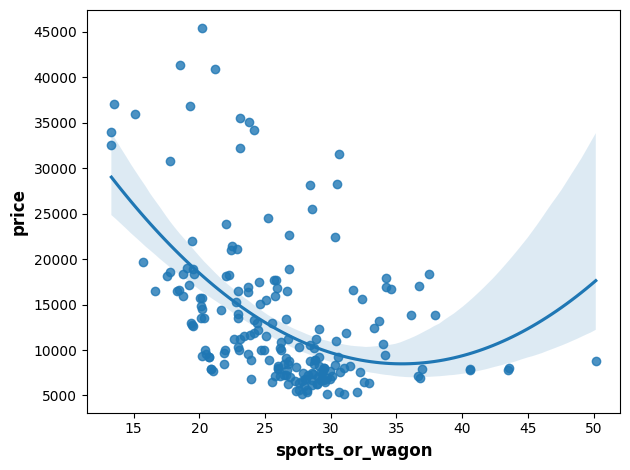

In [9]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);